В данном соревновании вам предстоит решить задачу бинарной классификации. Вам будут даны тренировочная (10000 примеров) и тестовая (2000) выборки. Количество признаков — 30.

Для успешного решения данного задания вам предстоит правильно настроить валидацию, провести отбор признаков и подобрать параметры для итоговой модели.

В результате, необходимо предсказать вероятности положительного класса для данных из тестовой выборки.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import f_classif, mutual_info_classif

In [3]:
import warnings
warnings.filterwarnings("ignore")

### Useful functions

In [4]:
def get_boxplot(column):
    
    # plot boxplots for numerical features
    
    fig, ax = plt.subplots(figsize=(14, 4))
    sns.boxplot(x='1', y=column,
                data=data,
                ax=ax, showmeans=True)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()
    
def vis_importance(xcol, ycol):
    
    # plot histograms for categorical features to visualize
    # dependence on target variable
    # xcol - feature to explore, ycol - target variable
    
    pd.crosstab(data[xcol], data[ycol]).plot(kind='bar')
    plt.title('Default frequency for {}'.format(xcol))
    plt.xlabel(xcol)
    plt.ylabel('Frequency of default')
    plt.show()
    
def outliers_detection(data, col):
    
    # detect outliers in data[col]
    
    perc25 = data[col].quantile(0.25)
    perc75 = data[col].quantile(0.75)
    IQR = perc75 - perc25
    left = perc25 - 1.5 * IQR
    right = perc75 + 1.5 * IQR
    print('min: {0}, max: {1}'.format(data[col].min(), data[col].max()))
    print('outlier boundaries: [{0}, {1}]'.format(left, right))
    if len(data[~data[col].between(left, right)]) > 0:
        print('ratio of outliers: {}'.format(len(data[(~data[col].between(left, right))&(~data[col].isna())])/len(data)))

def drop_outliers(data, col):
    
    # detect outliers in data[col]
    
    perc25 = data[col].quantile(0.25)
    perc75 = data[col].quantile(0.75)
    IQR = perc75 - perc25
    return data[(data[col].between(perc25 - 1.5 * IQR, perc75 + 1.5 * IQR))|(data[col].isna())]

### Load data

In [246]:
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')
train_target = pd.read_csv('input/train-target.csv')

In [110]:
train.shape, test.shape, train_target.shape

((9999, 30), (1999, 30), (9999, 1))

In [111]:
train.sample(5)

,-220.53052981117037,-70.19744010822103,119.03518124257707,20.711737029432243,-6.152985812887686,52.22505145235192,-23.23090327838962,-166.52187139825747,-41.57146270993908,2.620401107622818,...,16.93642041046429,46.54358453841927,-80.96217131632008,-146.65221819511046,10.899084620696035,4.370984578313747,4.060271578238659,40.68088991776954,-37.94265512724697,33.83822486571413
4928,-28.663246,-34.537247,-186.532237,103.357005,14.108038,-93.476911,3.771474,107.329317,78.191408,2.576561,...,-24.111675,12.937881,55.759366,-23.721239,-10.465722,0.329271,-2.760943,-92.698322,-74.302730,32.383859
3322,-189.110367,74.320180,-275.235617,-69.918057,-9.402118,-85.844573,-41.183051,-46.795816,-133.594961,0.052720,...,58.113417,214.187406,-23.030405,167.115799,-84.575114,-13.645962,0.394018,-118.932421,-8.217681,133.534639
2781,-151.771478,39.757724,-132.519092,57.251641,6.046021,47.903891,-58.983215,200.586913,-213.347218,2.668975,...,3.440124,-141.824765,102.350000,-123.193132,-36.368996,-1.890387,-0.698535,-145.583671,-44.121600,72.335149
6676,-327.198102,57.950459,-400.313988,5.617268,9.171950,-18.370738,241.783579,4.651883,-8.603135,2.661527,...,23.656840,8.872254,3.912824,-1.570046,-19.461854,-2.311725,0.781857,-120.229734,-50.376254,81.867262
9369,111.719488,-70.468505,55.559924,-200.539538,-4.717661,-5.019772,-69.777483,64.335817,-137.402654,0.074844,...,-68.764401,-106.634304,32.753095,-50.212877,169.710970,-8.631984,0.736495,-4.801608,52.253575,-56.735710


In [125]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   -220.53052981117037  9999 non-null   float64
 1   -70.19744010822103   9999 non-null   float64
 2   119.03518124257707   9999 non-null   float64
 3   20.711737029432243   9999 non-null   float64
 4   -6.152985812887686   9999 non-null   float64
 5   52.22505145235192    9999 non-null   float64
 6   -23.23090327838962   9999 non-null   float64
 7   -166.52187139825747  9999 non-null   float64
 8   -41.57146270993908   9999 non-null   float64
 9   2.620401107622818    9999 non-null   float64
 10  271.29225068198326   9999 non-null   float64
 11  2.695313032368222    9999 non-null   float64
 12  44.529272411508465   9999 non-null   float64
 13  12.998665666664078   9999 non-null   float64
 14  25.157747922290945   9999 non-null   float64
 15  2.1929308458742383   9999 non-null   f

### Data Analize

In [247]:
data = train.merge(train_target, how='left', left_index=True, right_index=True)

Text(0.5, 1.0, 'Histogram for default')

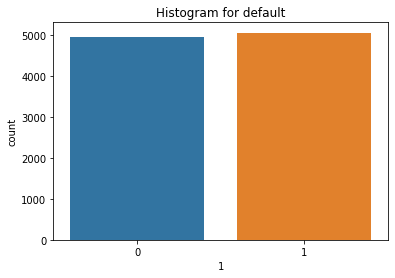

In [119]:
sns.countplot(data['1'])
plt.title('Histogram for default')

Целевая переменная поделена поровну (сбалансирована)

### Correlation matrix

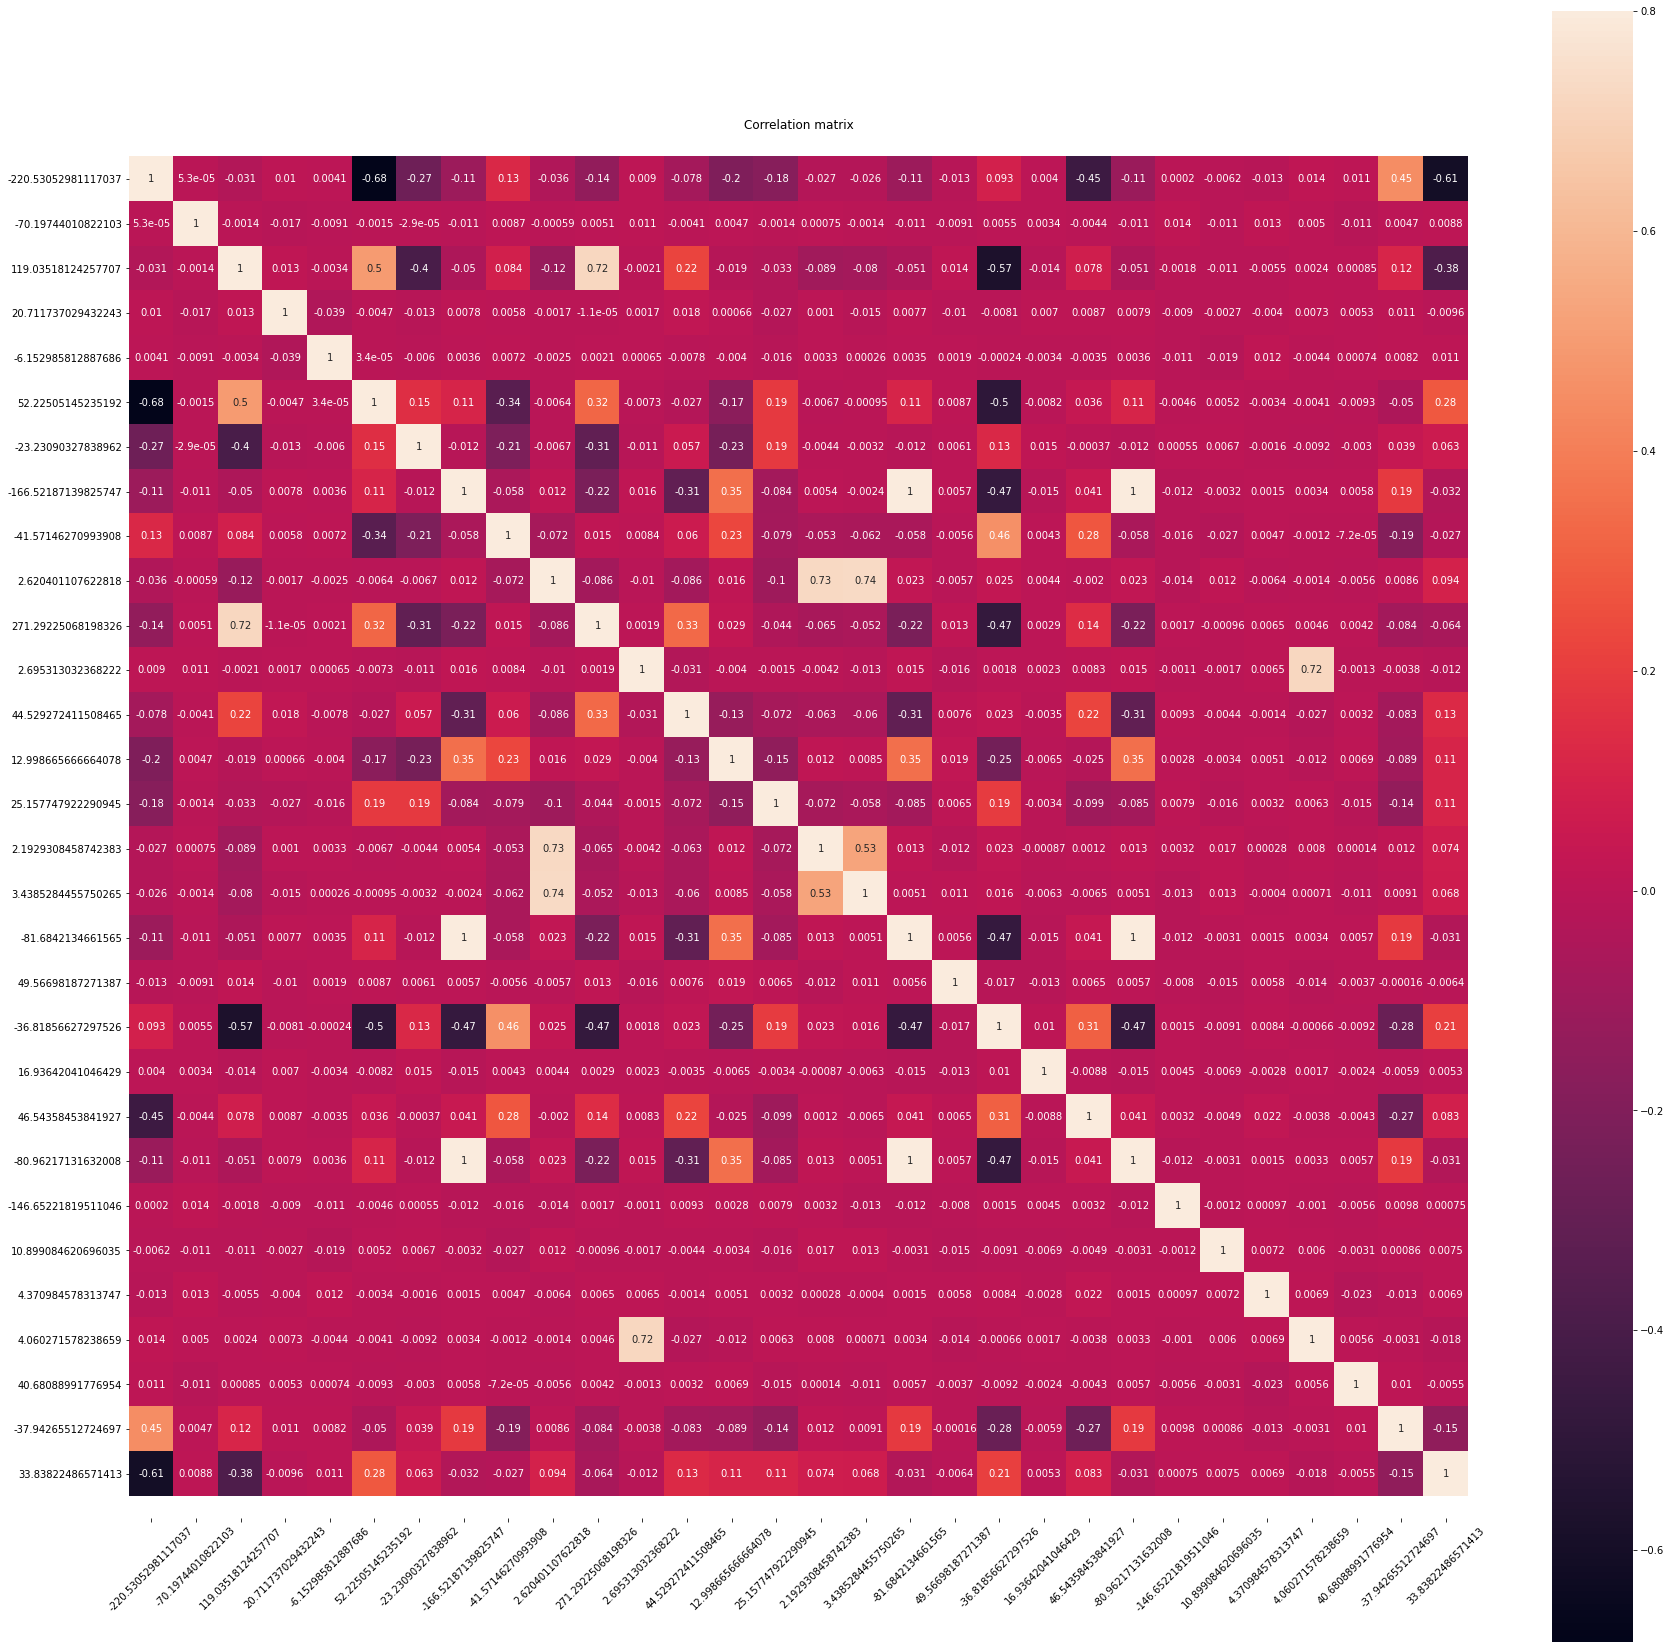

In [51]:
corrmat = train[train.columns.tolist()].corr()
f, ax = plt.subplots(figsize=(30, 30))
chart = sns.heatmap(corrmat, vmax=.8, square=True, annot=True)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
bottom, top = chart.get_ylim()
plt.title('Correlation matrix')
ax.set_ylim(bottom + 0.5, top - 0.5);

In [168]:
data.columns

Index(['-220.53052981117037', '-70.19744010822103', '119.03518124257707',
       '20.711737029432243', '-6.152985812887686', '52.22505145235192',
       '-23.23090327838962', '-166.52187139825747', '-41.57146270993908',
       '2.620401107622818', '271.29225068198326', '2.695313032368222',
       '44.529272411508465', '12.998665666664078', '25.157747922290945',
       '2.1929308458742383', '3.4385284455750265', '-81.6842134661565',
       '49.56698187271387', '-36.81856627297526', '16.93642041046429',
       '46.54358453841927', '-80.96217131632008', '-146.65221819511046',
       '10.899084620696035', '4.370984578313747', '4.060271578238659',
       '40.68088991776954', '-37.94265512724697', '33.83822486571413', '1'],
      dtype='object')

In [130]:
test.columns

Index(['394.6501011051649', '-102.77870316520904', '-48.85441624865759',
       '17.463192877435528', '4.744213702269446', '-90.50426012325909',
       '135.11115704308136', '-27.69150666378761', '192.96106701515134',
       '1.7552008501822347', '-213.13915721676628', '-1.3710319536768727',
       '167.22089608432248', '-438.69727282201205', '117.77672571288579',
       '2.678264119491712', '2.3362494445239728', '2.0986113182858963',
       '-131.89300315955606', '439.38612628926154', '-56.94716493248796',
       '140.95250626422802', '1.885744004554318', '11.48308573003449',
       '-131.66513217661793', '12.876561201764192', '0.15674658944486475',
       '-185.8490954610653', '-29.31471076141153', '-84.2544408988734'],
      dtype='object')

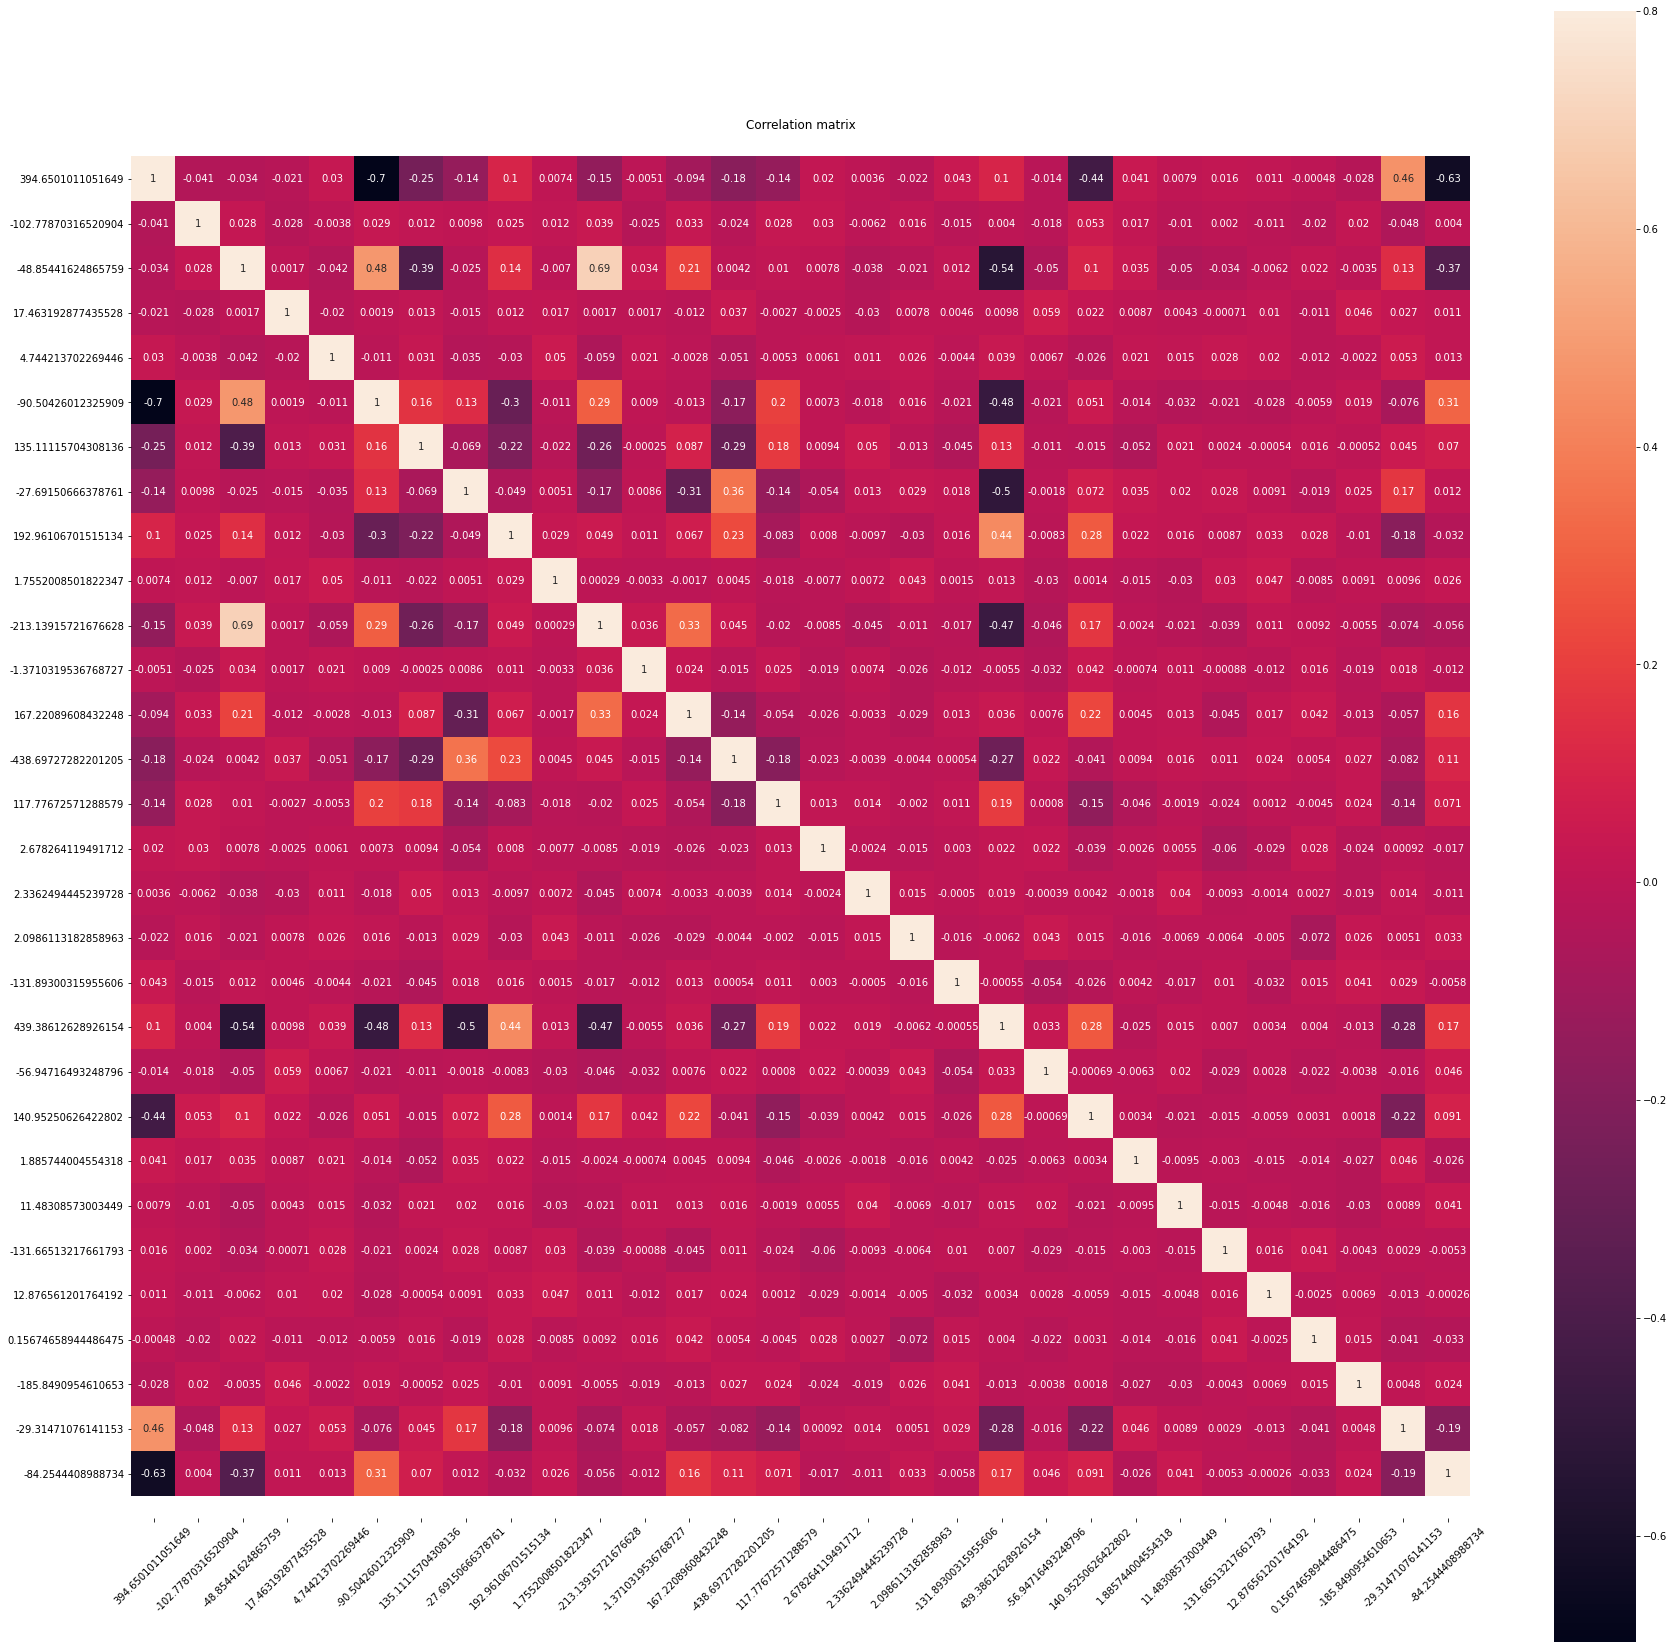

In [132]:
corrmat = test[test.columns.tolist()].corr()
f, ax = plt.subplots(figsize=(30, 30))
chart = sns.heatmap(corrmat, vmax=.8, square=True, annot=True)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
bottom, top = chart.get_ylim()
plt.title('Correlation matrix')
ax.set_ylim(bottom + 0.5, top - 0.5);

In [248]:
train = train.drop(train.columns[[17, 22, 7, 9]], axis='columns')

In [249]:
test = test.drop(test.columns[[17, 22, 7, 9]], axis='columns')

In [114]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   -220.53052981117037  9999 non-null   float64
 1   -70.19744010822103   9999 non-null   float64
 2   119.03518124257707   9999 non-null   float64
 3   20.711737029432243   9999 non-null   float64
 4   -6.152985812887686   9999 non-null   float64
 5   52.22505145235192    9999 non-null   float64
 6   -23.23090327838962   9999 non-null   float64
 7   -41.57146270993908   9999 non-null   float64
 8   271.29225068198326   9999 non-null   float64
 9   2.695313032368222    9999 non-null   float64
 10  44.529272411508465   9999 non-null   float64
 11  12.998665666664078   9999 non-null   float64
 12  25.157747922290945   9999 non-null   float64
 13  2.1929308458742383   9999 non-null   float64
 14  3.4385284455750265   9999 non-null   float64
 15  49.56698187271387    9999 non-null   f

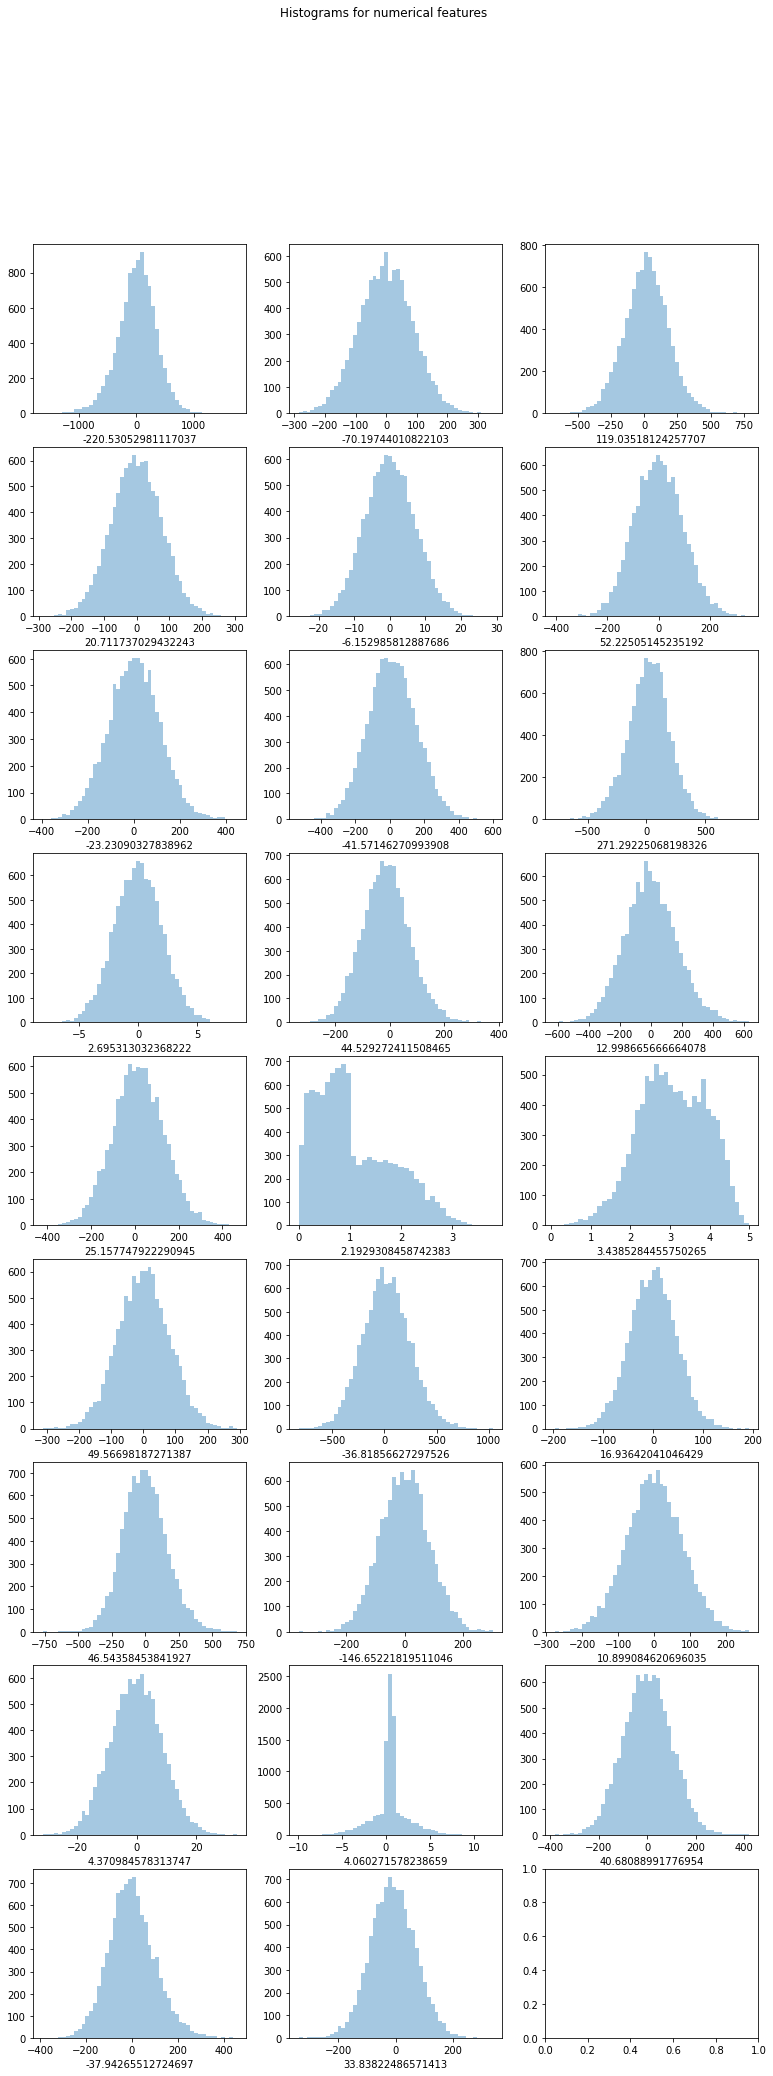

In [95]:
fig, axes = plt.subplots(9, 3, figsize=(13,33))
for col, i in zip(train.columns.tolist(), range(26)):
    sns.distplot(train[col], kde=False, ax=axes.flat[i])
fig.suptitle('Histograms for numerical features');

In [115]:
test.isnull().sum()

394.6501011051649      0
-102.77870316520904    0
-48.85441624865759     0
17.463192877435528     0
4.744213702269446      0
-90.50426012325909     0
135.11115704308136     0
192.96106701515134     0
-213.13915721676628    0
-1.3710319536768727    0
167.22089608432248     0
-438.69727282201205    0
117.77672571288579     0
2.678264119491712      0
2.3362494445239728     0
-131.89300315955606    0
439.38612628926154     0
-56.94716493248796     0
140.95250626422802     0
11.48308573003449      0
-131.66513217661793    0
12.876561201764192     0
0.15674658944486475    0
-185.8490954610653     0
-29.31471076141153     0
-84.2544408988734      0
dtype: int64

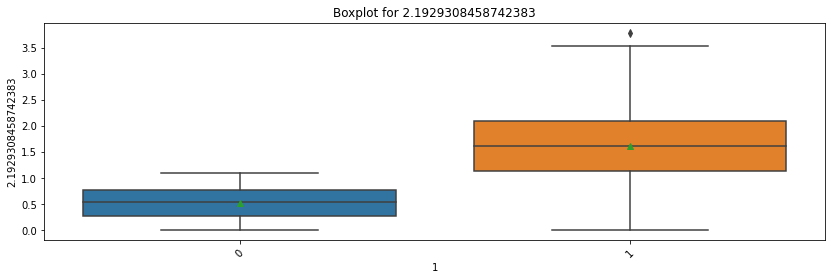

In [250]:
get_boxplot('2.1929308458742383')

Text(0.5, 0, 'F-value')

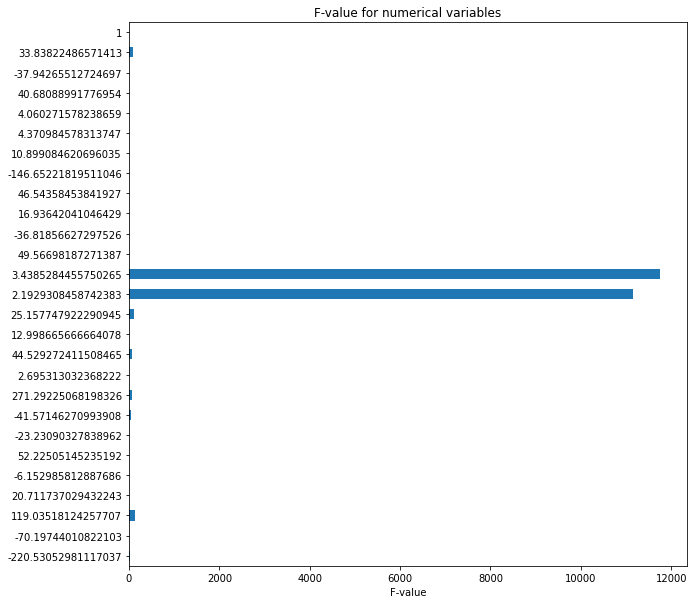

In [253]:
# check importance of numerical variables
imp_num = pd.Series(f_classif(data[data.columns.tolist()],
                              data['1'])[0], index=data.columns.tolist())
imp_num.plot(kind='barh')
plt.title('F-value for numerical variables')
plt.xlabel('F-value')

### Delete outliers

In [252]:
data = data.drop(data.columns[[17, 22, 7, 9]], axis='columns')

In [254]:
def delete_outliers(data, feature):
    q1 = data[feature].quantile(0.25)
    q3 = data[feature].quantile(0.75)
    iqr = q3 - q1
    fence_low = q1 - 1.5 * iqr
    fence_high = q3 + 1.5 * iqr
    data = data.loc[data[feature].between(fence_low, fence_high)]
    return data
print(f"Shape before: {data.shape}")

for col in data.columns:
    data = delete_outliers(data, col)
print(f"Shape after: {data.shape}")

Shape before: (9999, 27)
Shape after: (6165, 27)


### Data Preprocessing

In [6]:
# polynomial feature engeneering
train = PolynomialFeatures(2).fit_transform(train[train.columns.tolist()].values)[:,1:]

test = PolynomialFeatures(2).fit_transform(test[test.columns.tolist()].values)[:,1:]

### Scaler

In [8]:
train = sk.preprocessing.StandardScaler().fit_transform(train)

test = sk.preprocessing.StandardScaler().fit_transform(test)

In [11]:
train

array([[-0.06462555, -0.09122846, -0.8107972 , ..., -0.47418175,
         0.17606153, -0.68518845],
       [ 0.34226497,  1.52275618, -0.73696974, ...,  0.09638476,
         1.39718718,  0.28470561],
       [ 1.07696815,  0.13823544, -1.90258851, ...,  0.30004241,
        -0.10882055, -0.65639683],
       ...,
       [-0.58972551, -0.83872065, -1.43380806, ...,  2.11360261,
        -2.06925624,  0.13271791],
       [-0.84904336,  0.61060468, -1.16067632, ..., -0.64883655,
         0.17035694, -0.01057379],
       [-2.35251064, -1.54771493,  0.05443546, ..., -0.34495213,
        -0.3355107 , -0.33708358]])

### Model fitting

In [255]:
y = data['1'].values            # наш таргет
X = data.drop(['1'], axis=1)

# X = train
# y = train_target

# X.shape, y.shape

In [256]:
X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X, y, test_size=0.20, shuffle=True, random_state=45)

In [257]:
# проверяем еще раз размер выборок
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4932, 26), (1233, 26), (4932,), (1233,))

In [240]:
from sklearn.preprocessing import RobustScaler

In [241]:
r_scaler = RobustScaler()
r_X_train = r_scaler.fit_transform(X_train)
r_X_test = r_scaler.fit_transform(X_test)

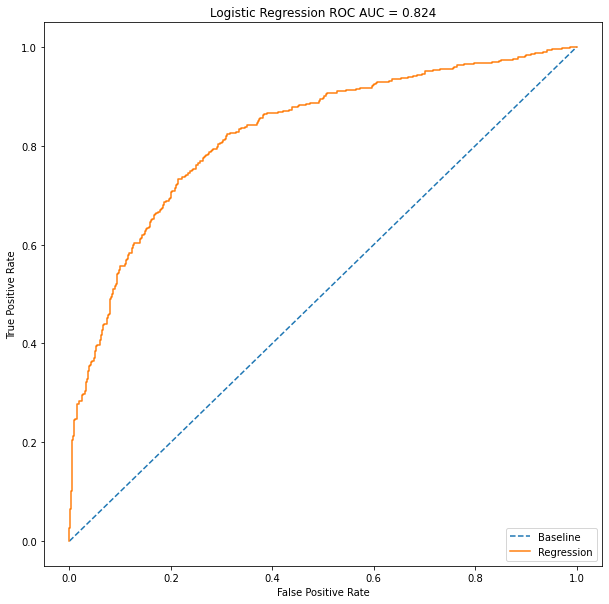

In [272]:
# LogisticRegression

log_reg = sk.linear_model.LogisticRegression(C=1.0, solver='liblinear', penalty='l2', max_iter=20, class_weight='balanced')
model_log_reg = log_reg.fit(X_train, y_train)
y_pred_probs = model_log_reg.predict_proba(X_test)[:, 1]

fpr, tpr, threshold = sk.metrics.roc_curve(y_test, y_pred_probs)
roc_auc = sk.metrics.roc_auc_score(y_test, y_pred_probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [95]:
C = np.logspace(0, 4, 10)
methods = ['liblinear', 'newton-cg', 'sag', 'saga', 'lbfgs']
hyperparameters = dict(C=C, solver=methods)
model = sk.linear_model.LogisticRegression(class_weight='balanced')
model.fit(X, y)

clf = sk.model_selection.GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X, y)

print('Лучший Solver:', best_model.best_estimator_.get_params()['solver'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

Лучший Solver: liblinear
Лучшее C: 1.0


In [187]:
log_reg = sk.linear_model.LogisticRegression(C=1.0, solver='liblinear', penalty='l1', max_iter=500, class_weight='balanced')
model_log_reg = log_reg.fit(X, y)
y_pred_probs = model_log_reg.predict_proba(test)

In [188]:
y_pred_probs.shape

(1999, 2)

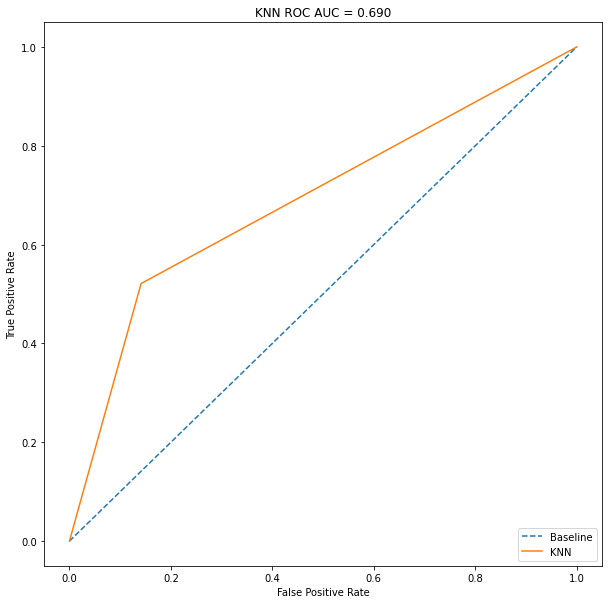

In [327]:
# KNN

# Импортируем необходимые библиотеки:

from sklearn.neighbors import KNeighborsClassifier


model_knn = KNeighborsClassifier(n_neighbors=10, weights='distance', algorithm='ball_tree')
model_knn.fit(X_train, y_train)
y_pred_knn = model_knn.predict(X_test)

fpr, tpr, threshold = sk.metrics.roc_curve(y_test, y_pred_knn)
roc_auc = sk.metrics.roc_auc_score(y_test, y_pred_knn)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'KNN')
plt.title('KNN ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [308]:
y_pred_knn = model_knn.predict(test)

knn_submission = pd.DataFrame(y_pred_knn)
knn_submission.to_csv('input/submission.csv', index=False)

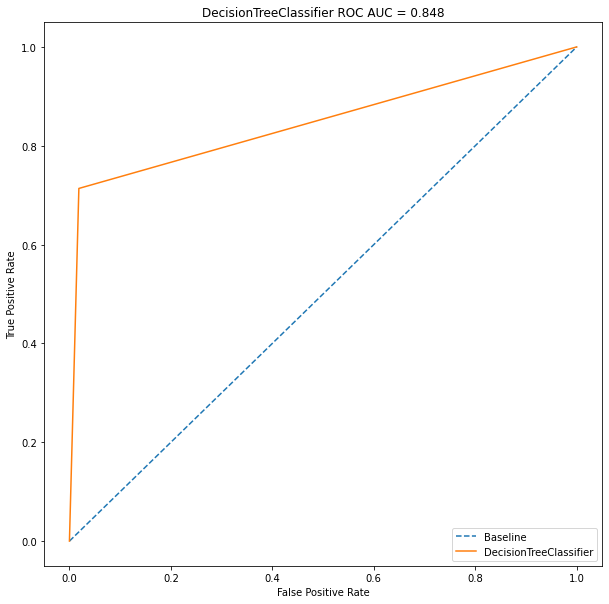

In [276]:
# RandomForestRegressor

# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn.tree import DecisionTreeClassifier
model_dtc = DecisionTreeClassifier(max_depth=5, random_state=456, max_features='sqrt', min_samples_leaf = 5)
# Обучаем модель на тестовом наборе данных
model_dtc.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model_dtc.predict(X_test)

fpr, tpr, threshold = sk.metrics.roc_curve(y_test, y_pred)
roc_auc = sk.metrics.roc_auc_score(y_test, y_pred)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'DecisionTreeClassifier')
plt.title('DecisionTreeClassifier ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [238]:
y_pred = model_dtc.predict(test)

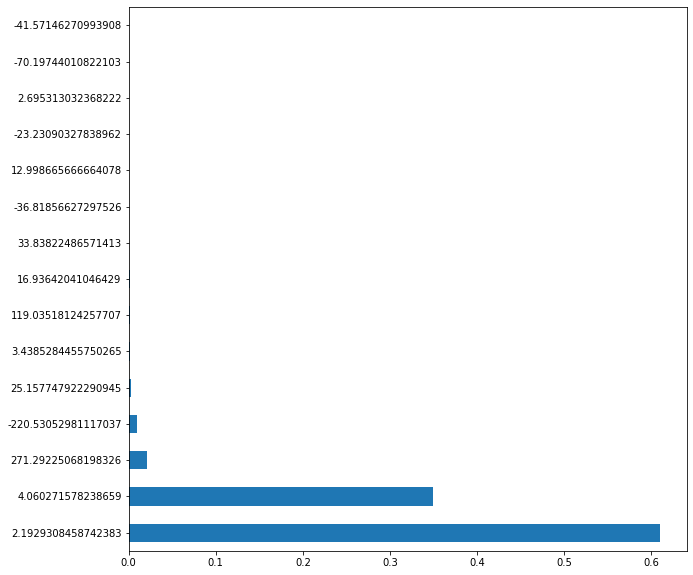

In [224]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

### Default - target variable

### Submissions

In [225]:
y_pred.shape

(1999,)

In [239]:
dtc_submission = pd.DataFrame(y_pred)
dtc_submission.to_csv('input/submission.csv', index=False)

In [192]:
y_pred_probs.shape

(1999, 2)

In [194]:
log_reg = pd.DataFrame(y_pred_probs[:, 1])
log_reg.to_csv('input/submission.csv', index=False)

In [70]:
my_submission.shape

(2000, 1)